# Predicting the Optimal Alloy Temperature for Steelmaking Process Optimization

## Technology Process Description

Steel is processed in an electric arc furnace with a vessel capacity of about 100 tons. In order for the vessel to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a vessel and heated to the desired temperature with graphite electrodes. They are installed in the lid of the vessel.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding alloy agents, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of the alloy from the bulk material hopper or wire.

Before adding alloying agents for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. After that, the molten steel is sent for metal finishing or enters the continuous casting machine.

The task of this study is to predict the temperature in the furnace. Thus, the company saves on energy costs. And it also ensures more stable product quality.

### Data Description

The data consists of files obtained from different sources:  

- `data_arc.csv` — electrodes data  
- `data_bulk.csv` — data on the supply of bulk materials (volume)  
- `data_bulk_time.csv` — data on the supply of bulk materials (time)  
- `data_gas.csv` — data on alloy gas purge  
- `data_temp.csv` — temperature measurement results  
- `data_wire.csv` — data on wire materials (volume)  
- `data_wire_time.csv` — data on wire materials (time)  

The `key` column in all files contains the batch number. There can be several rows in files with the same `key` value: they correspond to different processing iterations.

<b>The purpose of the study: </b>Develop a method for predicting steel temperature based on available indicators with a target MAE of at least 6.8.

### Roadmap of Research

1. Exploratory Data Analysis  
   Consider the available data, it types, missings, duplicates, basic statistics, plot graphs.
    
    
2. Data Cleaning and Preprocessing  
   We will fill in the missings if there are any. Some data perhaps have to be deleted. If necessary, we will perform data type conversions. We will also rename the column names in the tables for more convenient work.
    
    
3. Splitting data into samples  
   Split the data into training and test samples in the ratio of 75 to 25.
    

4. Feature Generation  
   As a target feature, we will take the last temperature measurement of the batch and not use intermediate measurements. The initial temperature value we'll use as one of the features for training models.
    
    
5. Model training  
   Train several different models: linear regression, extra trees and gradient boosting. Training will be carried out on cross-validation with the optimal hyperparameters tuning.


6. Testing the best model  
   Test the best model on a test set.


7. Study of the importance of features  
   After determining the best model, we'll evaluate the importance of the features.


8. Reporting  
   Based on the results of the study, we will draw up a report for the technologist of the enterprise.

## Exploratory Data Analysis

In [1]:
# Installing Required Library
!pip install shap

In [2]:
# Importing required libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

sns.set(rc={'figure.figsize':(15 ,9)}, palette='Set2', font_scale=1.25)

In [3]:
# Random state set up to project start date
RS = 11042023

In [4]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

In [5]:
# Placing variables with datasets in a dictionary and designate their names as keys
datasets = {'Electrodes data': data_arc, 
            'Data on bulk materials (volume)': data_bulk, 
            'Data on bulk materials (time)': data_bulk_time, 
            'Data on alloy gas purge': data_gas, 
            'Temperature measurement results': data_temp, 
            'Data on wire materials (volume)': data_wire, 
            'Data on wire materials (time)': data_wire_time}

### Data Exploration

Let's display the general information about the data - the first rows of the datasets, general information, the number of data missings in the columns and the general statistics.

In [6]:
class color:
    '''
    Helper-class for headlines highlighting
    '''
    BOLD = '\033[1m'
    END = '\033[0m'

for key, dataset in  datasets.items():
    print(color.BOLD + '='* len(key))
    print(key)
    print('='* len(key) + color.END, '\n')
    print(color.BOLD + 'Frist 5 rows of table:' + color.END)
    print(dataset.head(), '\n')
    print(color.BOLD + 'General Info:' + color.END)
    print(dataset.info(), '\n')
    print(color.BOLD + 'Number of missing values in columns:' + color.END)
    print(dataset.isna().sum(), '\n')
    print(color.BOLD + 'Statistics by columns:' + color.END)
    print(dataset.describe(), '\n')
    print(color.BOLD + 'Number of duplicates:' + color.END)
    print(dataset.duplicated().sum(), '\n\n\n')

Electrodes data

Frist 5 rows of table:
   key    Start heating arc      End heating arc  Active power  Reactive power
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02      0.976059        0.687084
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33      0.805607        0.520285
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36      0.744363        0.498805
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19      1.659363        1.062669
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37      0.692755        0.414397 

General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                14876 non-null  int64  
 1   Start heating arc  14876 non-null  object 
 2   End heating arc    14876 non-null  object 
 3   Active power       14876 non-null  float64
 4   Reactive power     14876 non-null  float64
dtypes: float64(2), int64(

At first glance it can be noted the following observations in the data:
- Large negative values of reactive power are observed. It should be observed further in details.
- Data missings on additives mean that this additive was not added during the melting of the batch. These missings can be filled in with zeros.
- There are missings in the temperature measurement. Since there is no way to recover the missing values, the records with the missing temperature should be deleted.
- Abnormally low temperatures (1191 deg.) are also present in the heating temperature data. The melting point of steel is usually 1300-1500 deg., respectively, all values below should be removed as outliers.
- For timestamped data, change the data type to datetime.
- No duplicates found in the data.

It should also be checked whether there is information in the datasets for all the batches.

In [7]:
# Finding it out through the sets

all_keys = set(data_arc['key'])

for key, data in datasets.items():
    print(f'Unique keys in Dataset {key}: {len(data["key"].unique())}')
    all_keys = all_keys.intersection(set(data['key']))
print()
print(f'Number of batches which containing all data in all the datasets: {len(all_keys)}')    

Unique keys in Dataset Electrodes data: 3214
Unique keys in Dataset Data on bulk materials (volume): 3129
Unique keys in Dataset Data on bulk materials (time): 3129
Unique keys in Dataset Data on alloy gas purge: 3239
Unique keys in Dataset Temperature measurement results: 3216
Unique keys in Dataset Data on wire materials (volume): 3081
Unique keys in Dataset Data on wire materials (time): 3081

Number of batches which containing all data in all the datasets: 3022


Let's take a closer look to data

### Electrodes Data

In [8]:
def distributions_plot(data, column, title):
    """
    The function plots two distribution graphs
    - boxplot
    - histogram
    """
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(data=data, x=column, ax=ax_box)
    sns.histplot(data=data, x=column, ax=ax_hist, bins=100)
    ax_box.set(xlabel='')

    fig.suptitle(title)
    plt.show();

#### Active Power

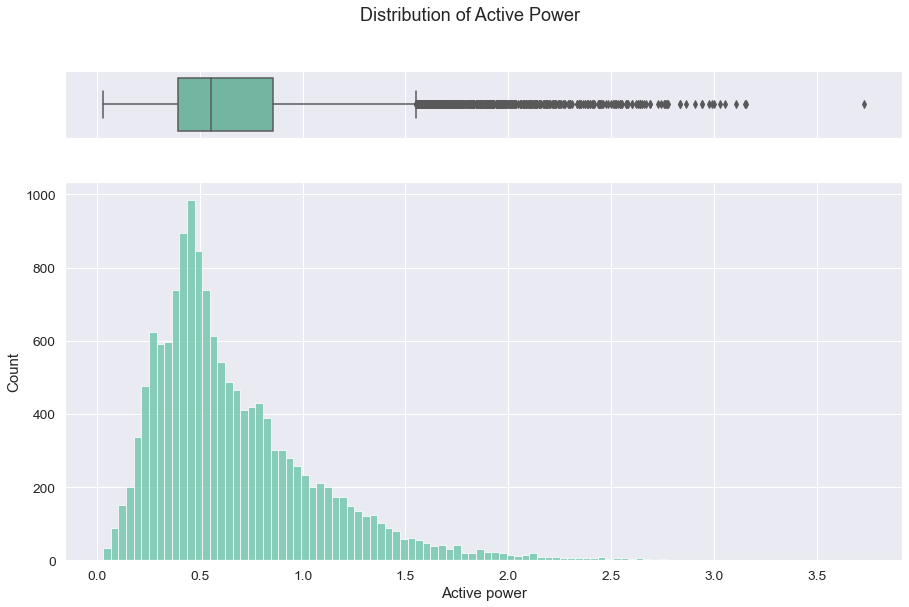

In [9]:
distributions_plot(data_arc, 'Active power', 'Distribution of Active Power')

#### Reactive Power

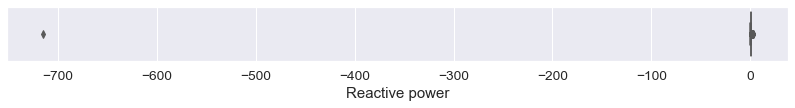

In [10]:
plt.subplots(figsize=(14, 1))
sns.boxplot(data=data_arc, x='Reactive power');

A significant outlier that we noticed in one of the previous steps. Let's look at the graph without it.

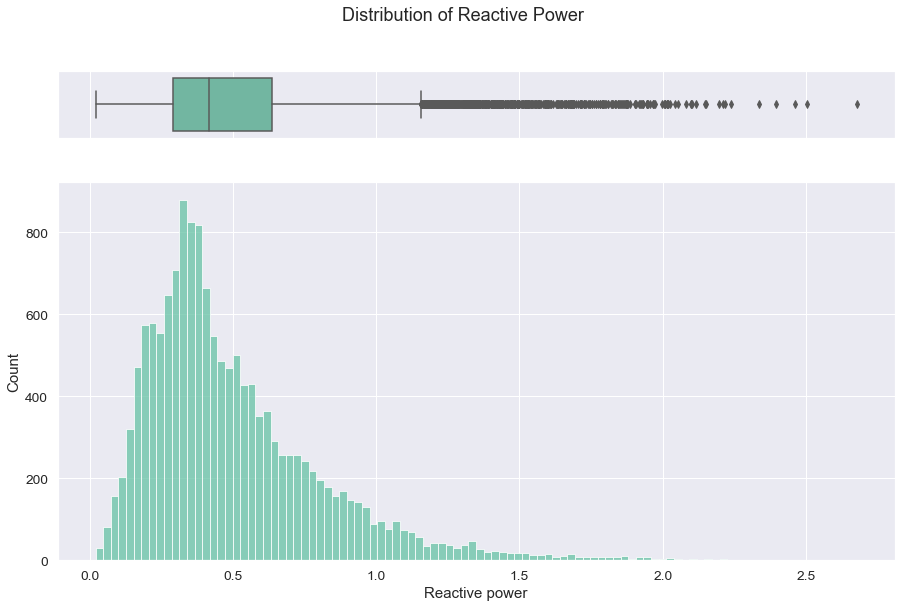

In [11]:
distributions_plot(data_arc[data_arc['Reactive power'] > - 700], 
                   'Reactive power', 
                   'Distribution of Reactive Power')

The distributions of active and reactive power are similar.

In [12]:
data_arc[data_arc['Reactive power'] < - 700]

,key,Start heating arc,End heating arc,Active power,Reactive power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


There is only one entry with a negative value of reactive power. We can delete the data for this batch. Beyond that, there are no any complaints on the heating data.

### Data on Bulk Materials (Volume)

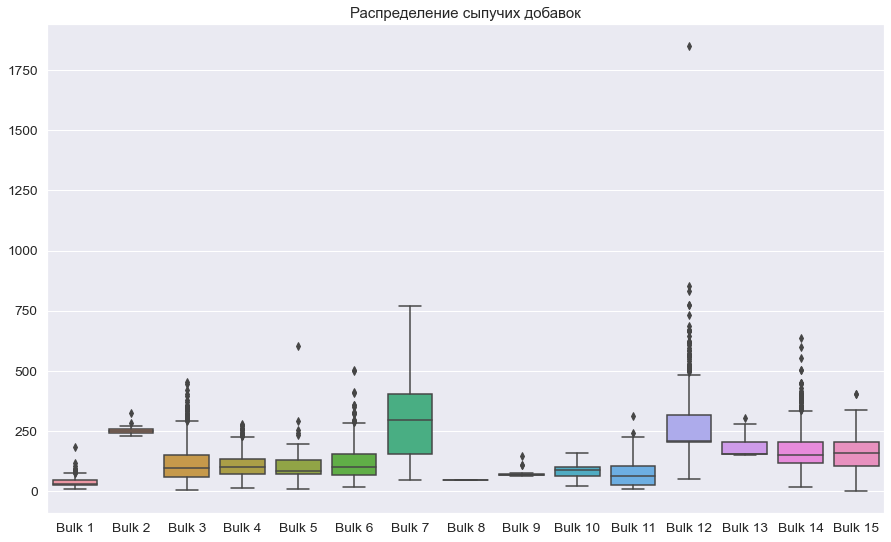

In [13]:
sns.boxplot(data = data_bulk.iloc[:, 1:])
plt.title('Bulk Materials Distribution');

It seems to be an outlier in the data for component 12. Also in the 5th component there is a strongly outlier value. Let's increase the size of graph by removing the biggest outlier from it.

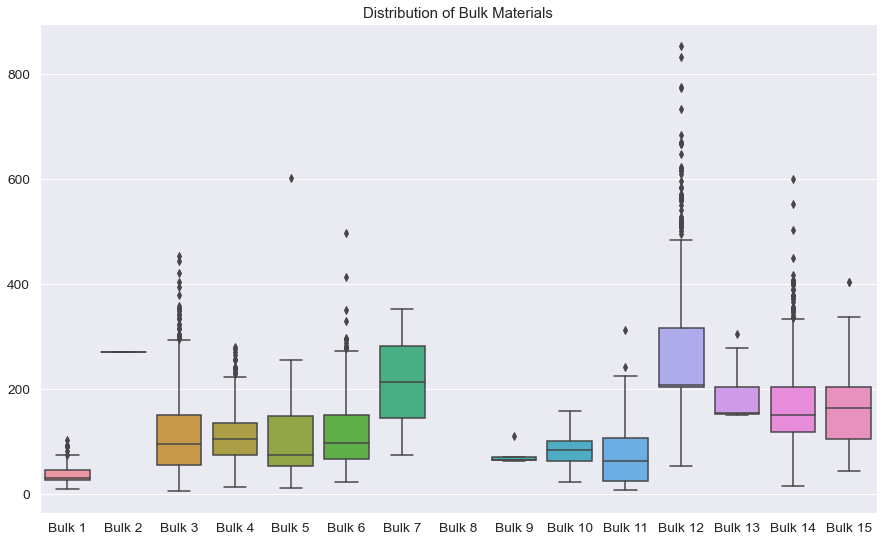

In [14]:
sns.boxplot(data = data_bulk.iloc[:, 1:][data_bulk['Bulk 12'] < 1500])
plt.title('Distribution of Bulk Materials');

The distributions by additives are quite heterogeneous. Some of them are symmetrical, some are the other way around. Some of the additives are added very often, some only once or just a few times.

### Data on Bulk Materials (Time)

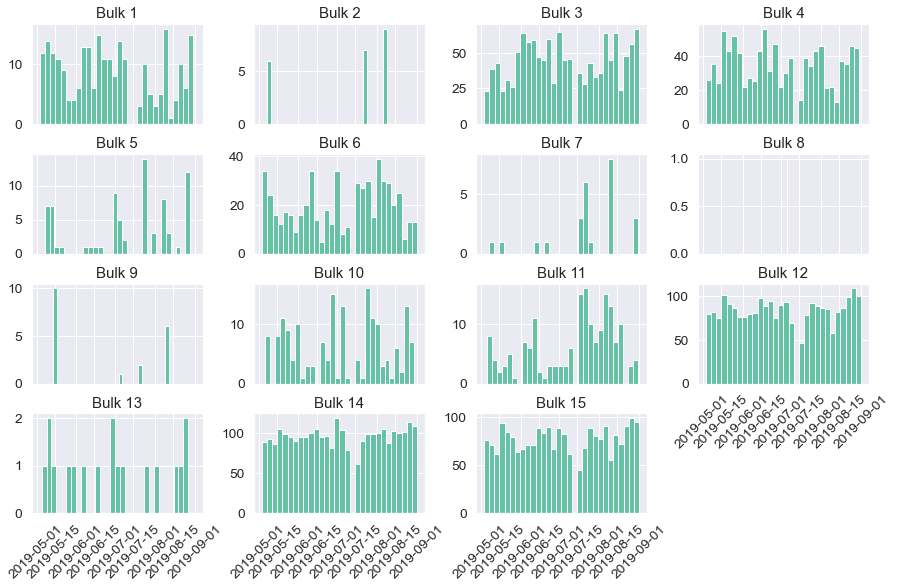

In [15]:
data_bulk_time.iloc[:,1:].astype('datetime64').hist(bins=30, 
                                                    sharex=True, 
                                                    xrot=45);

It can be observed that that some additives were used more often than others, some very rarely. For example Additive number 8 - only once. There is also a gap in time when nothing was added, perhaps production was stopped and repair or maintenance work was carried out.

### Alloy Gas Purge Data

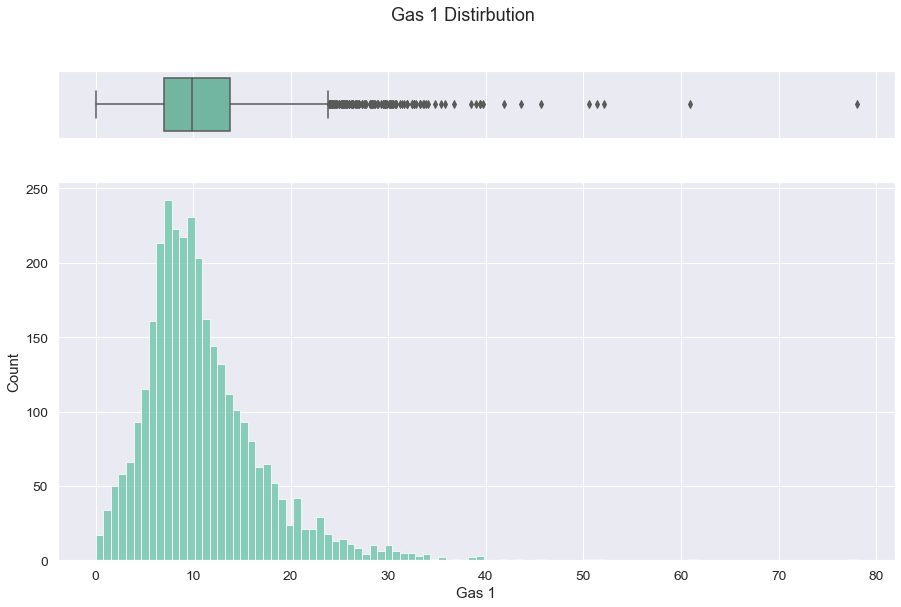

In [16]:
distributions_plot(data_gas, 'Gas 1', 'Gas 1 Distirbution')

There are some huge values. Perhaps the increase in gas purge time is due to the increase in the time of the entire process for the batch or experiments in technology process.

### Temperature Measurement Results

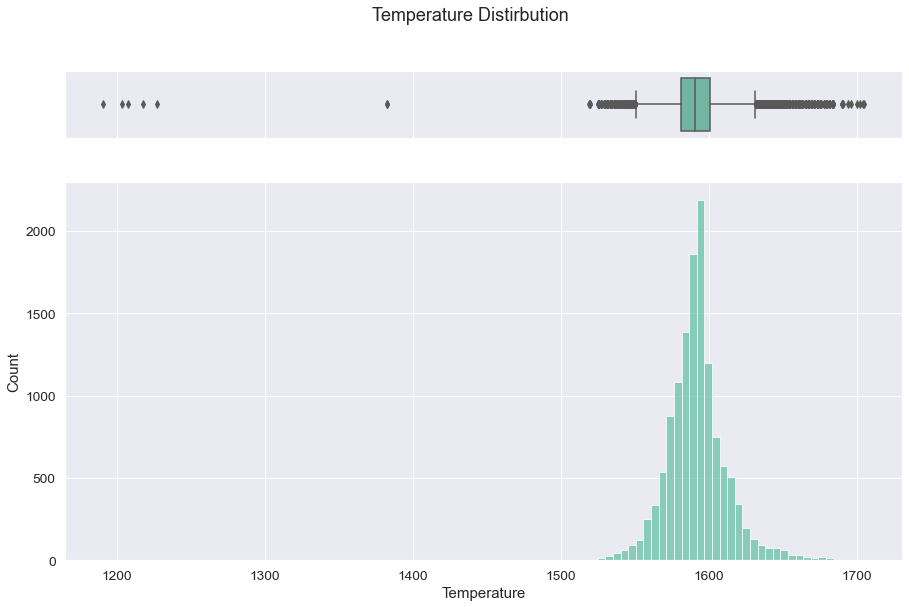

In [17]:
distributions_plot(data_temp, 'Temperature', 'Temperature Distirbution')

The graph shows several outliers around 1200 degrees and just below 1400 degrees.

In [18]:
data_temp[data_temp['Temperature'] < 1400]

,key,Measurment time,Temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


There are not many similar values, it would be better to remove them.

To train an ML model, we need two temperature values - initial and final. Let's calculate how many batches we have at least two temperature measurements.

In [19]:
(data_temp.loc[
    (data_temp['Temperature'].isna() == False) & 
    (data_temp['Temperature'] > 1500)]
 .groupby('key')['Temperature'].count() >= 2).sum()

2475

### Wire Materials Data (Volume)

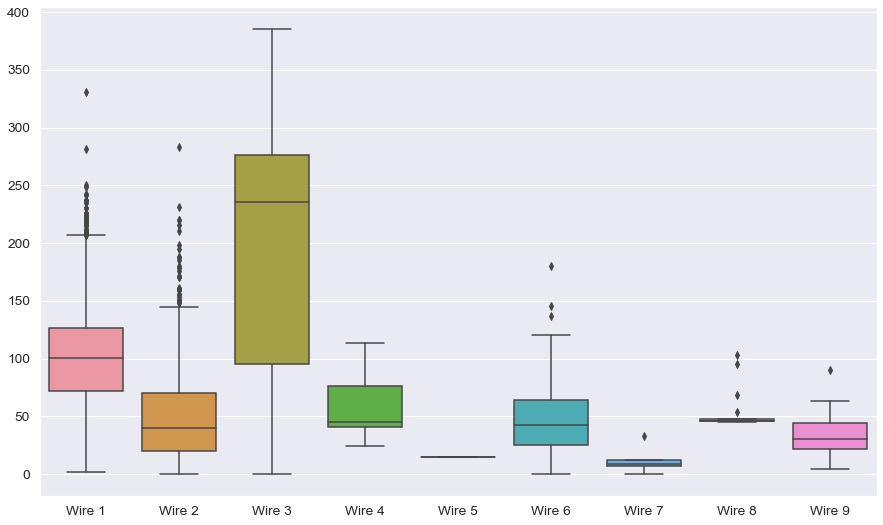

In [20]:
sns.boxplot(data=data_wire.iloc[:, 1:]);

In [21]:
data_wire[data_wire['Wire 5'].isna() == False]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2440,2567,18.30192,NaN,96.288193,NaN,15.132,73.307526,NaN,NaN,NaN


In general, the data is ok. For substance number 5, there is only one observation.

### Wire Materials Data (Time)

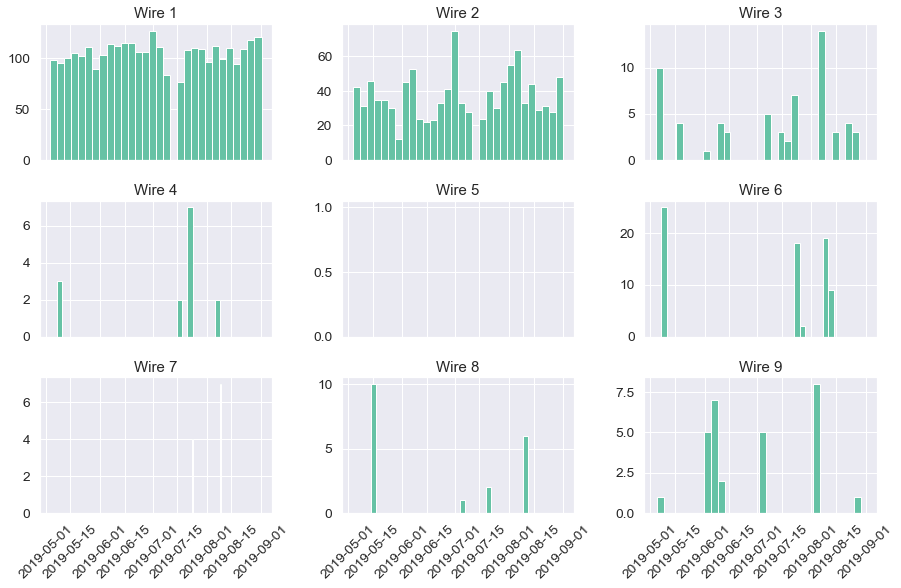

In [22]:
data_wire_time.iloc[:,1:].astype('datetime64').hist(bins=30, xrot=45, sharex=True);

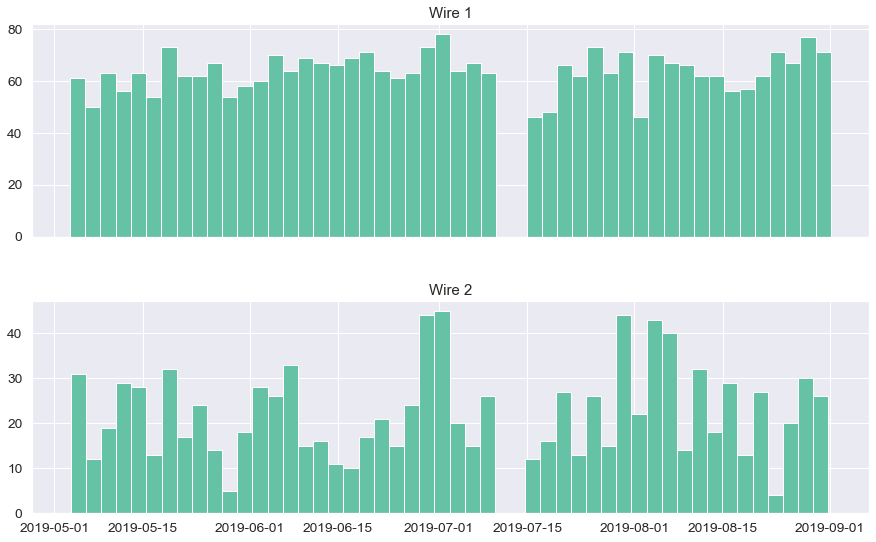

In [23]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
data_wire_time.iloc[:,1:2].astype('datetime64').hist(bins=50, ax=ax1)
data_wire_time.iloc[:,2:3].astype('datetime64').hist(bins=50, ax=ax2)
plt.show();

For wire materials, the situation is similar. The substances wire1 and wire2 are mainly used. A break in time is also noticeable, as in the graph for bulk materials.

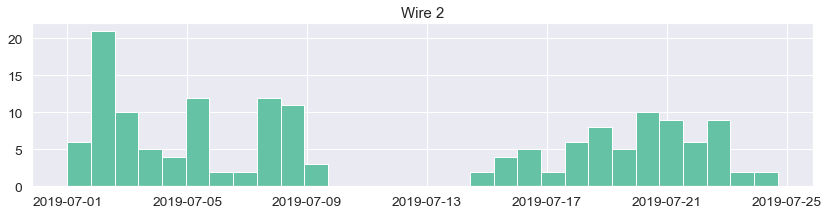

In [24]:
data_wire_time.iloc[:,2:3].astype('datetime64').loc[
    (data_wire_time['Wire 2'] > '2019-07-01') & 
    (data_wire_time['Wire 2'] < '2019-07-25')].hist(bins=30, figsize=(14, 3));

In [25]:
data_arc.loc[(data_arc['Start heating arc'] >= '2019-07-10') & 
             (data_arc['Start heating arc'] <= '2019-07-15')]

,key,Start heating arc,End heating arc,Active power,Reactive power
8728,1899,2019-07-10 00:35:25,2019-07-10 00:37:32,0.416167,0.361145
8729,1899,2019-07-10 00:44:50,2019-07-10 00:53:11,2.071217,1.714313
8730,1899,2019-07-10 00:54:37,2019-07-10 00:57:52,0.872728,0.612388
8731,1899,2019-07-10 00:59:13,2019-07-10 01:02:36,0.910008,0.616204
8732,1899,2019-07-10 01:04:59,2019-07-10 01:05:55,0.242389,0.179130
8733,1900,2019-07-14 23:17:28,2019-07-14 23:18:44,0.261596,0.203939
8734,1900,2019-07-14 23:23:26,2019-07-14 23:27:21,0.770129,0.573527
8735,1900,2019-07-14 23:51:38,2019-07-14 23:56:09,0.908687,0.813689


The electrode data also shows a break from 10 to 14 June. Since in this project we do not solve the problem of predicting time series, this feature of the data will not interfere with us in any way.

### Conclusion

7 different data sets were explored. The following observations have been done:

1. An outlier was detected in the electrode data table - a large negative value of reactive power. Probably caused by a malfunction in the meter. Data for this batch should be deleted.

2. Missing values were found in the data on the amount of additions. In this case missing values mean the absence of additives, therefore, the gaps are filled with zeros.

3. There are missing values in the temperature measurements. Since there is no way to recover the missing values, all the records with the missing temperature readings should be deleted.

4. There are also abnormally low temperatures in the data on the heating temperature. The melting temperature of steel is usually 1300-1500 degrees, so all values below should be removed as outliers.

5. For timestamped data, data type should be changed to datetime.

6. No duplicates found in the data.

7. It was also found out that not all batches have sufficient data for each dataset. The number of batches for which there are data in all datasets is 3022.

8. There are values in the data on the volumes of alloying additions that can be identified as outliers, but they should not be removed. These are probably technological experiments and you can try to train the model on them too.

9. Some additives are used much more often than others, some are used only once.

10. Breaks in the work of the enterprise are visible in the data.

## Data Cleaning and Preprocessing

Data cleaning and preprocessing consists of the following steps:
  1. Renaming columns
  2. Removal of batches with anomalies in temperature and negative reactive power
  3. Changing data types where it's necessary
  4. Filling in the missing values in the data_bulk and data_wire tables with zeros
  5. Mark gaps in temperature measurements with dummy-values
  6. Deletion of information on batches with less than two temperature measurements

In [26]:
def data_processing(data_arc, 
                    data_bulk, 
                    data_bulk_time, 
                    data_gas, 
                    data_temp, 
                    data_wire, 
                    data_wire_time):
    """
    Function for data cleaning and preprocessing
    """
    
    
    datasets = [data_arc, 
                data_bulk, 
                data_bulk_time, 
                data_gas, 
                data_temp, 
                data_wire, 
                data_wire_time]
    
    # Columns renaming
    data_arc.columns = ['key', 
                        'heating_start', 
                        'heating_end', 
                        'active_power', 
                        'reactive_power']
    data_gas.columns = ['key', 'gas']
    data_temp.columns = ['key', 'measure_time', 'temp']
    
    for dataset in [data_bulk, data_bulk_time, data_wire, data_wire_time]:
        dataset.columns = map(lambda x: x.lower().replace(' ', '_'), dataset.columns)
    
    
    # Removing anomalies
    anomaly_data_keys = []
    power_data_anomaly = data_arc[data_arc['reactive_power'] < 0]['key'].values
    anomaly_data_keys.extend(power_data_anomaly)
    keys_temp_anomaly = data_temp[data_temp['temp'] < 1500]['key'].values
    anomaly_data_keys.extend(keys_temp_anomaly)
    
    # Removing all the data with keys where anomalies were detected
    for dataset in datasets:
        dataset.drop(dataset.loc[(dataset['key'].isin(anomaly_data_keys))].index, inplace=True)
    
    # Data type changing
    data_arc[['heating_start', 'heating_end']] = \
        data_arc[['heating_start', 'heating_end']].astype('datetime64')
    data_bulk_time.iloc[:, 1:] = data_bulk_time.iloc[:, 1:].astype('datetime64')
    data_temp['measure_time'] = data_temp['measure_time'].astype('datetime64')
    data_wire_time.iloc[:, 1:] = data_wire_time.iloc[:, 1:].astype('datetime64')
    
    # Filling in data by zero-values
    data_bulk.fillna(0, inplace=True)
    data_wire.fillna(0, inplace=True)
    
    # Marking temperature missings by zeros
    data_temp.fillna(0, inplace=True)
    
    # Deleting all the data for batches where temperature missings were found
    temp_count = data_temp.groupby('key')['temp'].count()
    below_2_temp_keys = temp_count[temp_count < 2].index
    for dataset in datasets:
        dataset.drop(dataset.loc[(dataset['key'].isin(below_2_temp_keys))].index, inplace=True)
    
    return data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time

In [27]:
# Applying the function to data
(data_arc, 
 data_bulk, 
 data_bulk_time, 
 data_gas, 
 data_temp, 
 data_wire, 
 data_wire_time) = data_processing(data_arc, 
                                   data_bulk, 
                                   data_bulk_time, 
                                   data_gas, 
                                   data_temp, 
                                   data_wire, 
                                   data_wire_time)

## Feature Generation

The following features will be created:
  1. Data_arc table:
    - Heating time - the difference between the last and first heating
    - Full power - the square root of the sum of the squares of active and reactive power
    - Work - the product of full power and the heating time
    - If there were several heating cycles in the batch, then all values of heating time, total power and work are summarizinig. Only summarized data gets into the final table.
  
  2. Data_bulk and data_wire tables:
    - The sum of the masses of all additives
    - Number of different additives
    All original and newly created values fall into the final table.

  3. Data_temp table:
    - First, we make a summary table by the key-batch number, and as values we take the first and last temperature measurements and, accordingly, the first and last time marks of the measurement
    - Next, we create a time-gap feature - the time between the first and last measurements in seconds
    - We delete the data on timestamps, because they won't be needed anymore
    
  4. Table aggregation
    - We join the tables used in the generation of features using the left join method to the data_arc table
    - Delete lines in the temperature measurements of which there were gaps
    - Delete lines that still have gaps

In [28]:
def feature_generation(data_arc, 
                       data_bulk, 
                       data_bulk_time, 
                       data_gas, 
                       data_temp, 
                       data_wire, 
                       data_wire_time):
    """
    Function generates new features from existing data
    """
        
    # Data_arc feature generation
    data_arc['heating_time'] = (data_arc['heating_end'] - data_arc['heating_start']).dt.seconds
    data_arc['full_power'] = (data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2) ** 0.5
    data_arc['work'] = data_arc['full_power'] * data_arc['heating_time']
    data_arc_features = data_arc.pivot_table(index='key', values=['heating_time', 'full_power', 'work'], aggfunc='sum')
    
    # Bulk data feature generation
    data_bulk['bulk_sum'], data_bulk['bulk_num'] = \
    data_bulk.iloc[:, 1:].sum(axis=1), (15 - data_bulk.iloc[:, 1:].isin([0]).sum(axis=1))
    
    # Wire data feature generation
    data_wire['wire_sum'], data_wire['wire_num'] = \
    data_wire.iloc[:, 1:].sum(axis=1), (9 - data_wire.iloc[:, 1:].isin([0]).sum(axis=1))
    
    # Temperature measurments data feature generation
    data_temp_features = data_temp.pivot_table(index='key', values=['temp', 'measure_time'], aggfunc=['first', 'last'])
    data_temp_features.columns = ['start_measure_time', 'start_temp', 'end_measure_time', 'end_temp']
    data_temp_features['time_gap'] = (data_temp_features['end_measure_time'] - data_temp_features['start_measure_time']).dt.seconds
    data_temp_features.drop(['start_measure_time', 'end_measure_time'], axis=1, inplace=True)
    
    # Features aggregation
    data_features = data_arc_features.join(data_temp_features, how='left')
    data_features = data_features.join(data_bulk.set_index('key'), how='left')
    data_features = data_features.join(data_wire.set_index('key'), how='left')
    
    # Removing zero-marked temperature values
    data_features.drop(data_features.loc[data_features['end_temp'] == 0].index, inplace=True)
    
    # Removing all remaining data missings
    data_features.dropna(inplace=True)
    
    return data_features

In [29]:
data_features = feature_generation(data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time)

Let's find out how many records are left

In [30]:
len(data_features)

2326

During preprocessing, the number of records decreased by 23%.

### Correlations

Plotting a correlation matrix for our features

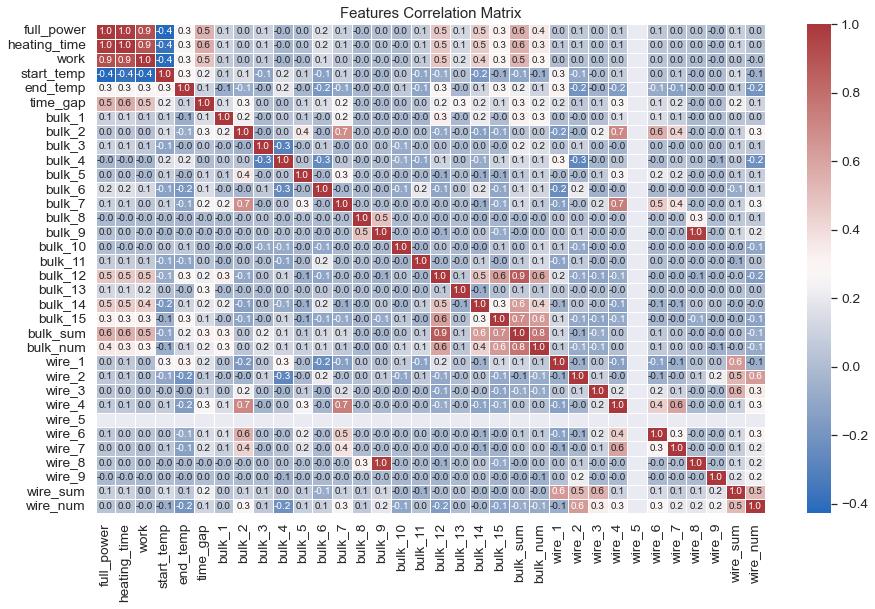

In [31]:
ax = plt.axes()
sns.heatmap(data_features.corr(), 
            fmt='.1f', 
            annot=True, 
            linewidth=.5, 
            cmap="vlag", 
            ax=ax, 
            annot_kws={"size":10})
ax.set_title('Features Correlation Matrix')
plt.show();



Many of the features we have created correlate with the target variable.
We can also notice multicollinearity in some of the features. Multicollinearity does not interfere with the training of 'tree' models, and linear regression with regularization is also resistant to multicollinearity, so we can leave all the features as they are.

### Splitting into Train and test sets

Splitting the data into training and test in the ratio of 75 to 25.

In [32]:
data_train, data_test = train_test_split(data_features, test_size=0.25, random_state=RS)

Removing those rows where the initial temperature is equal to the final one temperature in order to avoid leakage in train set only.

In [33]:
data_train.drop(data_train[data_train['start_temp'] == data_train['end_temp']].index, inplace=True)

### Features and target extraction

In [34]:
X_train = data_train.drop('end_temp', axis=1)
y_train = data_train['end_temp']
X_test = data_test.drop('end_temp', axis=1)
y_test = data_test['end_temp']

### Conclusion

- During cleaning and pre-processing, batch records with abnormal temperatures and negative reactive power were removed.
- Data from 7 different tables has been merged into one
- Created 10 new features
- The data was splitted into training and test sets
- Target and features were extracted

## Models Training

Creating a function for models training with cross-validation.

In [35]:
def model_learning_cv(estimator, features, target, params):
    """
    Function to training models with cross-validation.
    It takes as input a model, features, a target feature, 
    and a dictionary with iterated hyperparameters.
    Returns the best cross-validation score, the trained model, 
    and the set of best parameters.
    """
    pipe = Pipeline([('scaler', MinMaxScaler()),
                     ('est', estimator)])
    
    rs = RandomizedSearchCV(pipe, 
                            param_distributions=params, 
                            cv=5, 
                            random_state=RS, 
                            n_iter=20, 
                            scoring='neg_mean_absolute_error')
    rs.fit(features, target)
    
    return rs.best_score_, rs.best_estimator_, rs.best_params_

### Linear Regression Model

In [36]:
params_grid_lr = {'est__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'est__max_iter': [10000]}

In [37]:
scores_lr, model_lr, params_lr = model_learning_cv(SGDRegressor(random_state=RS), X_train, y_train, params_grid_lr)

The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.


In [38]:
scores_lr

-5.7841749935491205

The MAE value is quite good, well below the target.

### Extra Trees Model

In [39]:
params_grid_et = {'est__n_estimators': range(50, 500, 50),
             'est__max_depth': range(1, 22, 2),
             'est__min_samples_split': range(2, 11, 2),
             'est__min_samples_leaf': range(1, 11, 2)}

In [40]:
score_et, model_et, params_et = model_learning_cv(ExtraTreesRegressor(random_state=RS), X_train, y_train, params_grid_et)

In [41]:
score_et

-5.984871002392265

Also good MAE, well below the target.

### Gradient Boosting Model

In [42]:
params_grid_gb = {'est__learning_rate': np.arange(0.01, 0.2, 0.02),
             'est__n_estimators': range(50, 251, 50),
             'est__max_depth': range(1, 22, 2),
             'est__min_samples_leaf': range(1, 11, 2),
             'est__min_samples_split': range(2, 11, 2)}

In [43]:
scores_gb, model_gb, params_gb = model_learning_cv(GradientBoostingRegressor(random_state=RS), X_train, y_train, params_grid_gb)

In [44]:
scores_gb

-5.736482587162489

The MAE value for the gradient boosting model is better than the previous two models. For test, we chose the gradient boosting model.

### Conclusion

Cross-validation training was conducted on three different models:
  - Linear regression with elsticnet regularization
  - Extra Trees Forest
  - Gradient Boosting

Gradient boosting showed the best result. We make a choice in favor of this model and send it for verification.

## Best Model Test

Test the model on a test sample

In [45]:
predictions = model_gb.predict(X_test)

In [46]:
mean_absolute_error(y_test, predictions)

5.90445074784025

The value of the target metric is much less than what we need. The model passed the test.

### Adequacy Check

One more check the chosen model in comparison with the constant model

In [47]:
dummy = DummyRegressor(strategy='mean').fit(X_train, y_train)

In [48]:
pred = dummy.predict(X_test)

In [49]:
mean_absolute_error(y_test, pred)

7.76096011663022

The metric of best model is much better than the constant one. Adequacy test passed successfully.

### Conclusion

The test of the model for adequacy and on the test sample was successful. The value of the MAE metric was 5.90.

## Feature Importances Study

Let us check the importance of features of the best model. First, let's find the importance of features based on the criterion of the largest increase in information.

In [50]:
gb_feature_importance = pd.DataFrame(
    model_gb.steps[1][1].feature_importances_, 
    index=X_train.columns, 
    columns=['importance']).sort_values(by='importance', ascending=False)

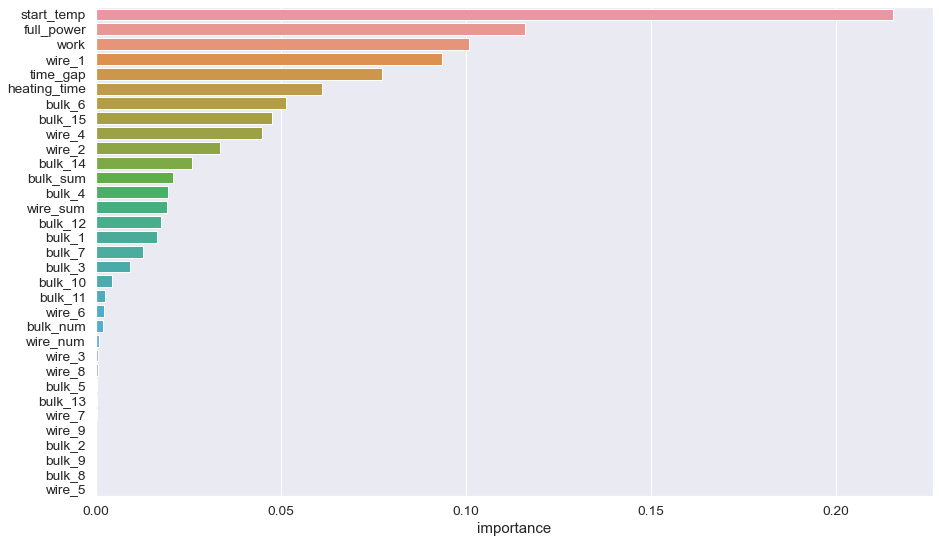

In [51]:
sns.barplot(data=gb_feature_importance, x='importance', y=gb_feature_importance.index);

Next, let's look at the importance of features calculated by the feature permutation method.

In [52]:
gb_feature_importance_perm = pd.DataFrame(
    permutation_importance(model_gb, X_test, y_test, random_state=RS, n_repeats=30)['importances_mean'], 
    index=X_train.columns, 
    columns=['importance']).sort_values(by='importance', ascending=False)

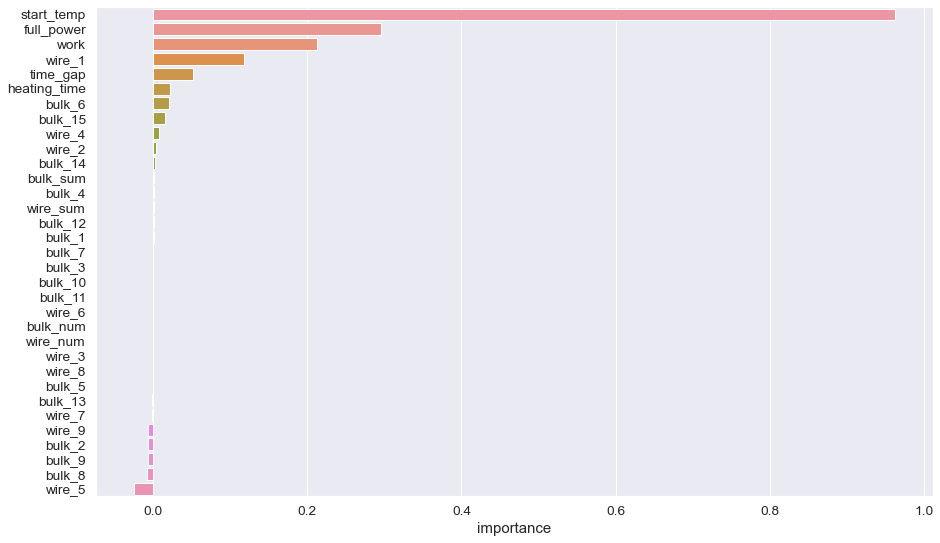

In [53]:
sns.barplot(data=gb_feature_importance_perm, x='importance', y=gb_feature_importance.index);

The order of importance remains almost the same, but the importance values are different. The most important indications here are initial temperature and gross power. Further, full work and the time between temperature measurements.

Now consider the importance of features using the shap method.

In [54]:
explainer = shap.explainers.Tree(model_gb.steps[1][1])
shap_values = explainer(X_test)

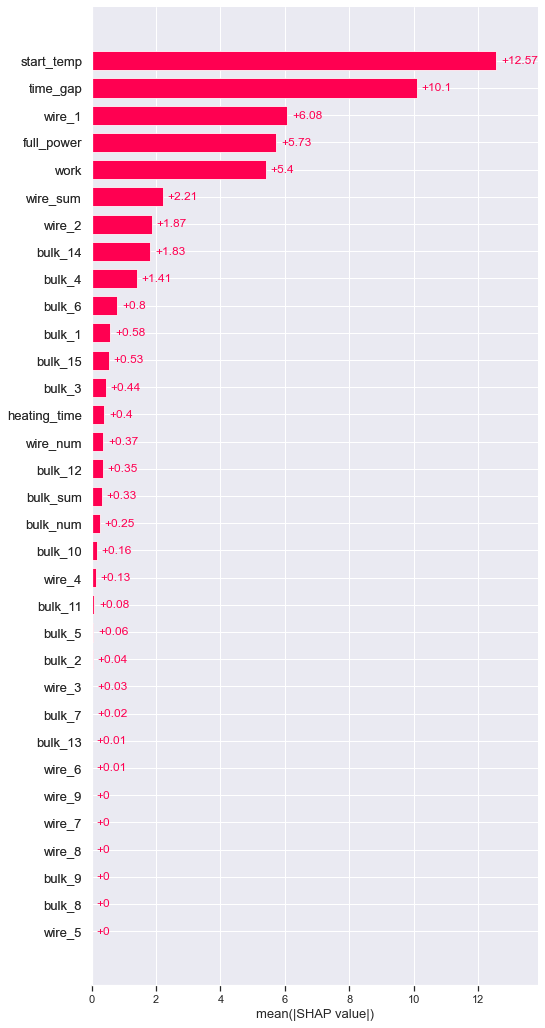

In [55]:
shap.plots.bar(shap_values, max_display=33)

In [56]:
# Creating a dataframe with feature importances by shap method
shap_importances = pd.DataFrame(map(lambda x: abs(np.mean(x)), shap_values.values.T),
                                index=X_train.columns, 
                                columns=['importance']).sort_values(by='importance', ascending=False)

Here, the importance of features is distributed in a different order. The most important feature is the time between temperature measurements and the initial temperature. Further, the total power and volume of the wave additive number 1.

### Developing a lightweight model

We will conduct an experiment based on the results of the study of the feature importances. We will train the model only on the ten most important features and calculate the target metric. Since we have some highly correlated features we'll also transform the features by Principal Component Analysis (PCA) method during the model training.

Selection the most important features

In [57]:
def n_importance_filter(n, *importances):
    '''
    The function takes as input n - the number of features of the greatest 
    importance and sorted dataframes with feature_importance
    Returns an array with the most important features.
    '''
    importances = [*importances]
    features_num = len(importances[0])
    result = set(importances[0].index)
    
    while features_num >= n and len(result) >= n:
        result = set(importances[0][:features_num].index)
        for imp in importances[1:]:
            result.intersection(set(imp[:features_num].index))
        features_num -= 1
    
    return np.array([*result])

Top 5 and Top 10 Important Features

In [58]:
most_important5 = n_importance_filter(5, shap_importances, gb_feature_importance, gb_feature_importance_perm)

In [59]:
most_important5

array(['work', 'time_gap', 'wire_1', 'start_temp', 'full_power'],
      dtype='<U10')

In [60]:
def model_cv_wtrans(estimator, features, target, params):
    first_transformer = Pipeline([("scaler", MinMaxScaler())])
    second_transformer = Pipeline([('scaler', MinMaxScaler()),
                                    ('pca', PCA())])

    
    preprocessor = ColumnTransformer(
    transformers=[
        ("pass", first_transformer, features.columns),
        ("pca", second_transformer, most_important5)
        ])
    
    
    pipe = Pipeline([('prep', preprocessor),
                     ('est', estimator)])
    
    rs = RandomizedSearchCV(pipe, 
                            param_distributions=params, 
                            cv=5, 
                            random_state=RS, 
                            n_iter=20, 
                            scoring='neg_mean_absolute_error')
    rs.fit(features, target)
    
    return rs.best_score_, rs.best_estimator_, rs.best_params_

Training the model

Creating the datasets with the most important features only.

In [61]:
scores_gb_imp, model_gb_imp, params_gb_imp = model_cv_wtrans(GradientBoostingRegressor(random_state=RS), X_train, y_train, params_grid_gb)

In [62]:
scores_gb_imp

-5.463551121256462

In [65]:
params_gb_imp

{'est__n_estimators': 100,
 'est__min_samples_split': 4,
 'est__min_samples_leaf': 1,
 'est__max_depth': 5,
 'est__learning_rate': 0.08999999999999998}

Model test

In [63]:
predictions = model_gb_imp.predict(X_test)

In [64]:
mean_absolute_error(y_test, predictions)

5.371254064100116

The final quality of the model became even better and gives an excellent result. In industrial use, this model will be much more convenient, because. now only 10 features will need to be used to predict temperature instead of 33.

### Conclusion

The five most important features are:
- Total work
- Full power
- Time between first and last temperature reading
- Wire_1
- Initial temperature

## Summary

1. There are 7 different data sets were explored. The following observations have been done:  
   - An outlier was detected in the electrode data table - a large negative value of reactive power. Probably caused by a malfunction in the meter. Data for this batch should be deleted.  
   - Missing values were found in the data on the amount of additions. In this case missing values mean the absence of additives, therefore, the gaps are filled with zeros.  
   - There are missing values in the temperature measurements. Since there is no way to recover the missing values, all the records with the missing temperature readings should be deleted.  
   - There are also abnormally low temperatures in the data on the heating temperature. The melting temperature of steel is usually 1300-1500 degrees, so all values below should be removed as outliers.  
   - For timestamped data, data type should be changed to datetime.  
   - No duplicates found in the data.  
   - It was also found out that not all batches have sufficient data for each dataset. The number of batches for which there are data in all datasets is 3022.  
   - There are values in the data on the volumes of alloying additions that can be identified as outliers, but they should not be removed. These are probably technological experiments and you can try to train the model on them too.  
   - Some additives are used much more often than others, some are used only once.  
   - Breaks in the work of the enterprise are visible in the data.  


2. Data cleaning and preprocessing.  
   - Renaming columns  
   - Removal of batches with anomalies in temperature and negative reactive power  
   - Changing data types where it's necessary  
   - Filling in the missing values in the data_bulk and data_wire tables with zeros  
   - Mark gaps in temperature measurements with dummy-values  
   - Deletion of information on batches with less than two temperature measurements  
  
  
3. The following features were generated:  
    - Heating time - the difference between the last and first heating  
    - Full power - the square root of the sum of the squares of active and reactive power  
    - Work - the product of full power and the heating time  
    - The sum of the masses of all additives  
    - Number of different additives  
    - First and last temperature measurements and, accordingly, the first and last time marks of the measurement  
    - Time-gap feature - the time between the first and last measurements in seconds  
    - Unnecessary columns were deleted, tables were aggregated, rows were deleted in the temperature measurements of which there were gaps, records were deleted in which there was only one temperature measurement.
  
  
4. The data were splitted into two sets - training and test in the ratio of 75 to 25. In the training set, data with a leak on the target attribute were removed.
  
  
5. Trained three different ML models.
    - Linear regression with l2 regularization
    - Extra Trees Forest
    - Gradient boosting
    
    Gradient boosting showed the best result. We make a choice in favor of this model and send it for test.
    
    
6. Checking the model for adequacy and on the test set was successful. The value of the MAE metric was 5.90.  
  
  
7. A study of the importance of features was carried out.
    The five most important features:
    - Work
    - Wire_1
    - Time between first and last temperature reading
    - Initial temperature
    - Full power
    

8. A light version of the model with 10 features and additional transformation of features has been develpoed. It performs even better results. MAE of lightweight model is 5.37 on a test set.

## Report for the Chief Technologist of the Enterprise

The study was conducted according to the original plan without significant deviations. The data for the study were provided by the customer himself. During the study of the provided data, the following problems and features in the data were discovered:  
  - Anomalous temperature values and a negative value of reactive power were detected.  
  - Timestamps for certain processes from different data sets are not synchronized with each other  
  - About 20% of all measurements are missing from the temperature measurement data  
  - In all tables there are gaps in the data for certain parties. In total, data on 7% of batches are missing.  
Data for all batches in which anomalies and omissions were encountered had to be deleted  
  
In connection with the above features, it was decided to take only the first and last temperature measurements for research and predict, respectively, only the final temperature.  
  
For the prediction research of the final temperature, the following features were also taken:  
- Data on the volume of gas blown through the alloy  
- Data on the volume of all bulk and wire additives  
  
The following features were also created based on the available data:  
- Total heating time (the sum of the differences between the last and first heating times for each of the batch heating cycles)  
- Full power (square root of the sum of the squares of active and reactive power over the entire batch)  
- Total work (full power multiplied by heating time in total for all batch heating cycles)  
- The sum of the masses of all additives (separately for bulk and wire)  
- The number of different additives (also separately for bulk and wire)  
- Time between first and last reading in seconds  

Three different machine learning models were explored - Linear Regression Model (SGD), Extra-Trees, Gradient Boosting. All three models showed good results when training on cross-validation, but gradient boosting showed better results than the other two models, so the choice fell on gradient boosting model.  

Hyperparameters of the final model:  
Number of decision trees (n_estimators): 100  
Minimum split criterion (min_samples_split): 4  
Minimum number of leafs (min_samples_leaf): 1  
Maximum tree depth (max_depth): 5  
Learning rate (learning_rate): 0.09  
  
When training on cross-validation, the average MAE value for these hyperparameters was 5.74, on the test set 5.90, which is significantly lower than the threshold target value set by the customer (MAE 6.8). In other words, this model can, on average, be wrong in predicting the temperature within +-5.65 degrees, which can provide some margin in real work.
  
Next, a study was conducted on the subject of the strongest factors influencing the accuracy of model predictions. According to the results of the study, 5 most important features for predicting the final temperature were found:  
- Complete work  
- Full power  
- Time between first and last temperature reading  
- Quantity of wire additive number 1  
- Initial temperature  
  
Based on this, another model was trained, for which only top 10 features are needed (which will be much more convenient when used in production). The accuracy of the lightweight model is even higher (MAE 5.37) because in lightweight model additional data transformations used.

Basic recommendations for the technologist of the enterprise.
1. Ensure more accurate data collection and minimize possible loss of measurement data.
2. Synchronize timestamps across all processes. In this way, it will be possible to try to explore, for example, the influence of the time of adding alloying components and possibly make more accurate forecasts, and also try to use a different approach - time series prediction.
3. Keep a record of the MAE metric (the absolute value of the difference between the predicted and actual temperature value) of the quality of the prediction and monitor the dynamics of its change. Over time, for example, with changes in technology or raw materials, the metric may deteriorate and additional training of the model will be required.  